In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import json
import glob

In [2]:
# Taken from Prof. Sievers simple_read_ligo.py
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [3]:
# List of events
eventnames = [ 'GW150914' , 'GW151226' , 'GW170104' , 'LVT151012' ]

In [4]:
# Taken from the LOSC_Event_tutorial notebook
# Read the event properties from a local json file
fnjson = "LOSC_Event_tutorial/LOSC_Event_tutorial/BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# 1)

### Noise models for Livingston and Hanford will be assumed as stationary. To smooth the noise, a gaussian convolution kernel shall be used. Finally, the window function used will be a tukey window which has an extended flat perdiod useful for our situation

In [39]:
# Tukey window code taken from https://leohart.wordpress.com/2006/01/29/hello-world/
def tukeywin(window_length, alpha=0.5):
    '''The Tukey window, also known as the tapered cosine window, can be regarded as a cosine lobe of width \alpha * N / 2
    that is convolved with a rectangle window of width (1 - \alpha / 2). At \alpha = 0 it becomes rectangular, and
    at \alpha = 1 it becomes a Hann window.
 
    We use the same reference as MATLAB to provide the same results in case users compare a MATLAB output to this function
    output
 
    Reference
    ---------
    http://www.mathworks.com/access/helpdesk/help/toolbox/signal/tukeywin.html
 
    '''
    # Special cases
    if alpha <= 0:
        return np.ones(window_length) #rectangular window
    elif alpha >= 1:
        return np.hanning(window_length)
 
    # Normal case
    x = np.linspace(0, 1, window_length)
    w = np.ones(x.shape)
 
    # first condition 0 <= x < alpha/2
    first_condition = x<alpha/2
    w[first_condition] = 0.5 * (1 + np.cos(2*np.pi/alpha * (x[first_condition] - alpha/2) ))
 
    # second condition already taken care of
 
    # third condition 1 - alpha / 2 <= x <= 1
    third_condition = x>=(1 - alpha/2)
    w[third_condition] = 0.5 * (1 + np.cos(2*np.pi/alpha * (x[third_condition] - 1 + alpha/2))) 
 
    return w

def coswin(n):
    x = np.linspace(0,2,n) * np.pi
    return 0.5-0.5*np.cos(x)


def convolve_gauss(data,npix=10):
    x = np.linspace(-len(data)/2,len(data)/2,len(data))
    npix = 10
    sigma = npix/2
    gau = np.exp(-0.5*(x/sigma)**2) / (sigma*np.sqrt(2*np.pi))
    gau /= np.sum(gau)
    gau = np.fft.fftshift(gau)
    
    return np.fft.irfft( np.fft.rfft(data) * np.fft.rfft(gau) , len(data))

def convolve_box(data,npix=10):
    box = np.zeros(len(data))
    box[:npix] = 1
    box[-npix+1:] = 1
    box /= np.sum(box)
    return np.fft.irfft( np.fft.rfft(data) * np.fft.rfft(box) , len(data))

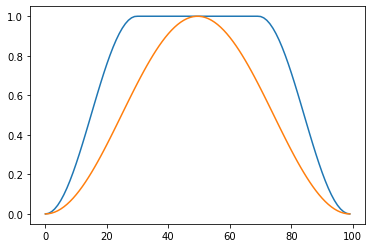

In [6]:
twin = tukeywin(100 , alpha=0.6)
plt.figure(); plt.plot(twin)

x = np.linspace(0,2,len(twin)) * np.pi
cwin = 0.5-0.5*np.cos(x)
plt.plot(cwin)



reading file  LOSC_Event_tutorial/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
reading file  LOSC_Event_tutorial/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5


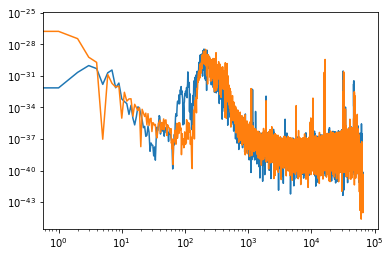

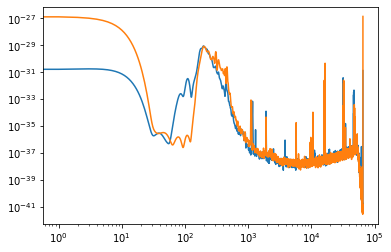

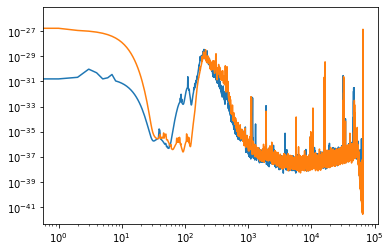

In [60]:
event = events[eventnames[0]]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform

diri = 'LOSC_Event_tutorial/LOSC_Event_tutorial/'

# Initializing strain data
fname_H = diri+fn_H1
print('reading file ',fname_H)
strain_h,dt_h,utc_h=read_file(fname_H)
fname_L = diri+fn_L1
print('reading file ',fname_L)
strain_l,dt_l,utc_l=read_file(fname_L)

# Initializing templates
template_name=diri+fn_template
th,tl=read_template(template_name)

# Defining a window
windy = tukeywin(len(strain_h) , alpha=0.6)
windy_normfac = np.sqrt(np.mean(windy**2))

# Applying window to strains and templates
windy_strain_h = windy * strain_h
windy_strain_l = windy * strain_l
windy_th = windy * th
windy_tl = windy * tl

# FTs of windowed data
strain_h_ft = np.fft.rfft(windy_strain_h)/windy_normfac
strain_l_ft = np.fft.rfft(windy_strain_l)/windy_normfac

# Initializing noise estimates
N_han = np.abs(strain_h_ft)**2
N_liv = np.abs(strain_l_ft)**2
plt.figure()
plt.loglog(N_han); plt.loglog(N_liv)

# Smoothing noise estimates
N_han_smooth = convolve_gauss(N_han , 10)
N_liv_smooth = convolve_gauss(N_liv , 10)
plt.figure()
plt.loglog(N_han_smooth); plt.loglog(N_liv_smooth)

# Trying our best to not overweight the undesired noise due to smoothing
N_han = np.maximum(N_han,N_han_smooth)
N_liv = np.maximum(N_liv,N_liv_smooth)
plt.figure()
plt.loglog(N_han); plt.loglog(N_liv)

# 2)

In [63]:
diri = 'LOSC_Event_tutorial/LOSC_Event_tutorial/'
MFs_h = [None] * len(eventnames)
MFs_l = [None] * len(eventnames)

for i,eventname in enumerate(eventnames):
    
    event = events[eventname]
    fn_H1 = event['fn_H1']              # File name for H1 data
    fn_L1 = event['fn_L1']              # File name for L1 data
    fn_template = event['fn_template']
    
    # Initializing strain data
    strain_h,dt_h,utc_h=read_file(diri+fn_H1)
    strain_l,dt_l,utc_l=read_file(diri+fn_L1)

    # Initializing templates
    th,tl=read_template(diri+fn_template)
    
    # Defining a window
    windy = tukeywin(len(strain_h) , alpha=0.6)
    windy_normfac = np.sqrt(np.mean(windy**2))

    # Applying window to strains and templates
    windy_strain_h = windy * strain_h
    windy_strain_l = windy * strain_l
    windy_th = windy * th
    windy_tl = windy * tl

    # FTs of windowed data and templates
    strain_h_ft = np.fft.rfft(windy_strain_h) / windy_normfac
    strain_l_ft = np.fft.rfft(windy_strain_l) / windy_normfac
    th_ft = np.fft.rfft(windy_th) / windy_normfac
    tl_ft = np.fft.rfft(windy_tl) / windy_normfac
    
    # Performing matched filtering
    mf_h = np.fft.irfft( np.conj(th_ft) * (strain_h_ft)/N_han )
    mf_l = np.fft.irfft( np.conj(tl_ft) * (strain_l_ft)/N_liv )
    MFs_h[i] = mf_h
    MFs_l[i] = mf_l
    
    print('done event #'+str(i+1))

done event #1
done event #2
done event #3
done event #4


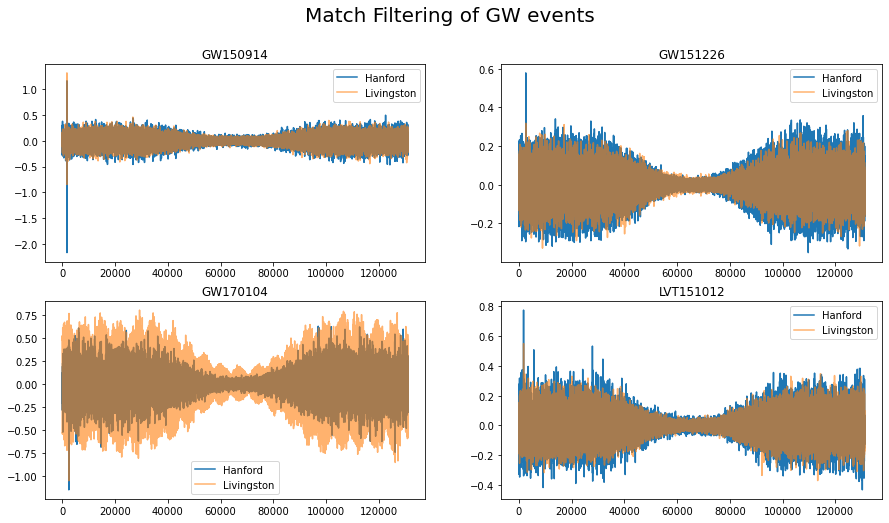

In [64]:
fig , ax = plt.subplots(2,2,figsize=(15,8))
fig.suptitle('Match Filtering of GW events' , size=20)
for i in range(len(eventnames)):
    ax.flat[i].set_title(eventnames[i])
    ax.flat[i].plot(MFs_h[i] , label = 'Hanford')
    ax.flat[i].plot(MFs_l[i] , label = 'Livingston' , alpha=0.6)
    ax.flat[i].legend()

# 3)

In [66]:
noise_estim_boundries = [5000,30000]
snr_h = np.zeros(len(eventnames))
snr_l = np.zeros(len(eventnames))
for i in range(len(eventnames)):
    snr_h[i] = np.max(np.abs(MFs_h[i])) / np.std(MFs_h[i][ noise_estim_boundries[0]:noise_estim_boundries[1] ])
    snr_l[i] = np.max(np.abs(MFs_l[i])) / np.std(MFs_l[i][ noise_estim_boundries[0]:noise_estim_boundries[1] ])
    print('For event',eventnames[i],':, (Hanford, Livingston) showed SNR of',(snr_h[i],snr_l[i]))

For event GW150914 :, (Hanford, Livingston) showed SNR of (17.660652140694967, 11.829487882855316)
For event GW151226 :, (Hanford, Livingston) showed SNR of (5.904036751199203, 4.18084632471643)
For event GW170104 :, (Hanford, Livingston) showed SNR of (6.7930713995174115, 3.0201004131143536)
For event LVT151012 :, (Hanford, Livingston) showed SNR of (6.924618284924224, 5.852752148770201)
